## Doublet Removal - scDblFinder
### Setup and Load Data
Data files are in the 'filtered_feature_bc_matrix' folder along with other output from CellRanger. 

On the question of whether to run cell filtering before or after doublet detection using scDblFinder the program authors say:


The input to scDblFinder should not include empty droplets, and it might be necessary to remove cells with a very low coverage (e.g. <200 reads) to avoid errors. Further quality filtering should be performed downstream of doublet detection, for two reasons: 1. the default expected doublet rate is calculated on the basis of the cells given, and if you excluded a lot of cells as low quality, scDblFinder might think that the doublet rate should be lower than it is. 2. kicking out all low quality cells first might hamper our ability to detect doublets that are formed by the combination of a good quality cell with a low-quality one. Unless QC filtering is very stringent (and it shouldn’t be!), it’s unlikely to make a big difference.

In [5]:
import scanpy as sc
import numpy as np
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import os
import anndata

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

sample_name = r'sc85_1g'

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.10.3 anndata==0.11.0 umap==0.5.7 numpy==1.26.4 scipy==1.14.1 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.11.8 louvain==0.8.2 pynndescent==0.5.13
scanpy==1.10.3 anndata==0.11.0 umap==0.5.7 numpy==1.26.4 scipy==1.14.1 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.11.8 louvain==0.8.2 pynndescent==0.5.13


#### Setup R environment

In [6]:
import os
os.environ['R_HOME'] = r"C:\Program Files\R\R-4.4.2"  
import anndata2ri # order matters, comes after defining 'R_HOME
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%reload_ext rpy2.ipython

C:\Users\leeh1\AppData\Local\Temp\ipykernel_11004\364680306.py:9: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [7]:
%%R
.libPaths(c("C:/Users/leeh1/AppData/Local/R/win-library/4.4", .libPaths()))
library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)

#### Load data

Read in count data into an [`AnnData`](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) object.  
The matrix.mtx file contains a sparse matrix of the counts.  
Barcodes file contains the sample names in the format: AAACCCAAGACCATAA-1  
Features file contains the gene id in the format: ENSMUSG00000051951, Xkr4, Gene Expression

The number of counts per cell will be relatively low since only UMIs are counted by Cellranger

In [8]:
adata = anndata.read_h5ad("pseudo_doublets_sc85_1g.h5ad")                # write a cache file for faster subsequent reading

# adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
print('Data matrix is sparse:', scipy.sparse.issparse(adata.X))
print()

print('Number of cells =', f"{adata.n_obs:,.0f}")
print('Number of genes =', f"{adata.n_vars:,.0f}")
print('Number of counts =', f"{adata.X.sum():,.0f}")
print('Mean counts per cell =', f"{adata.X.sum()/adata.n_obs:,.0f}")
adata

print()
print(adata.obs)

Data matrix is sparse: True

Number of cells = 14,480
Number of genes = 25,051
Number of counts = 6,061,941
Mean counts per cell = 419

                          doublet
rDbl.1                        1.0
rDbl.2                        1.0
rDbl.3                        1.0
rDbl.4                        1.0
rDbl.5                        1.0
...                           ...
TTTGTTGGTTAAGTGT_sc85_1g      0.0
TTTGTTGGTTACGCGG_sc85_1g      0.0
TTTGTTGGTTAGGATT_sc85_1g      0.0
TTTGTTGGTTGCCTCA_sc85_1g      0.0
TTTGTTGGTTGGCGTG_sc85_1g      0.0

[14480 rows x 1 columns]


In [9]:
n_cells = adata.n_obs
n_genes = adata.n_vars
n_counts = adata.X.sum()    
counts_per_cell = round(n_counts / n_cells)

df_metrics = pd.DataFrame([n_cells, n_genes, n_counts, counts_per_cell], \
                  index = ['Number of cells', 'Number of genes', 'Number of counts','Mean counts per cell']).T
df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1:].applymap('{:,.0f}'.format)
df_metrics.index = [sample_name]
df_metrics

C:\Users\leeh1\AppData\Local\Temp\ipykernel_11004\1815972615.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1:].applymap('{:,.0f}'.format)
C:\Users\leeh1\AppData\Local\Temp\ipykernel_11004\1815972615.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0    25,051
Name: Number of genes, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1:].applymap('{:,.0f}'.format)
C:\Users\leeh1\AppData\Local\Temp\ipykernel_11004\1815972615.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0    6,061,941
Name: Number of counts, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1:

,Number of cells,Number of genes,Number of counts,Mean counts per cell
sc85_1g,14480.0,"25,051","6,061,941",419


### Detect doublets
Remove "empty" genes before doublet detection.

In [10]:
sc.pp.filter_genes(adata, min_cells=1)
df_metrics['Filter genes:'] = ' '
df_metrics['Number of genes removed'] = n_genes - adata.n_vars

filtered out 490 genes that are detected in less than 1 cells


In [11]:
data_mat = adata.X.T                 # transform data matrix
doublet_ratio = n_cells/1000*0.008   # calculate multiplet rate based on 10x formula
print('multiplet rate = %4.1f' %(doublet_ratio*100), '%')

multiplet rate = 11.6 %


In [12]:
%%R -i data_mat -i doublet_ratio -o doublet_score -o doublet_class

set.seed(123)
sce = scDblFinder(SingleCellExperiment(list(counts=data_mat),), dbr=doublet_ratio)
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

Creating ~11584 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 1641 cells excluded from training.
iter=1, 1161 cells excluded from training.
iter=2, 1125 cells excluded from training.
Threshold found:0.491
1106 (7.6%) doublets called
In addition: Warning message:
In .checkSCE(sce) :
  Some cells in `sce` have an extremely low read counts; note that these could trigger errors and might best be filtered out


In [13]:
doublets = [1.0 if x == 'doublet' else 0 for x in doublet_class]
adata.obs["scDblFinder_score"] = doublet_score
adata.obs["scDblFinder_class"] = doublet_class
adata.obs["doublet"] = doublets

In [14]:
doublet_percentage = sum(doublets)/adata.n_obs*100
print('Doublet percentage = %4.1f' %(doublet_percentage))
df_metrics['Doublet removal:'] = ' '
df_metrics['Doublet percentage'] =  doublet_percentage

adata.obs.scDblFinder_class.value_counts()

Doublet percentage =  7.6


scDblFinder_class
singlet    13374
doublet     1106
Name: count, dtype: int64

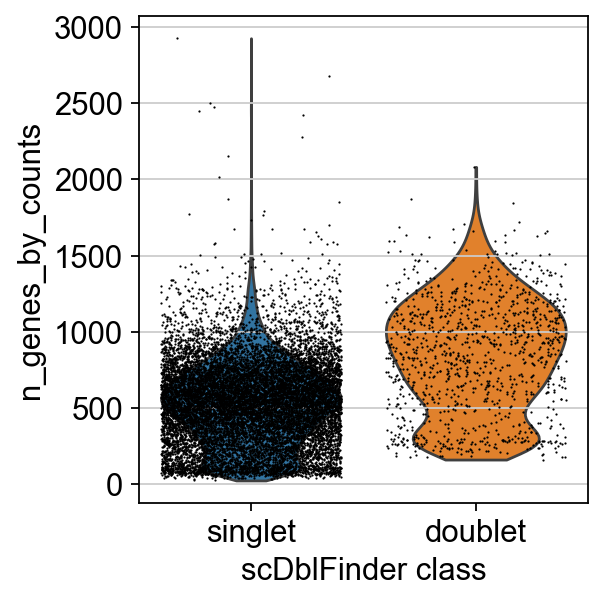

In [15]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, 'n_genes_by_counts',jitter=0.4, groupby = 'scDblFinder_class')

In [16]:
num_before = adata.n_obs
singlets = adata.obs["scDblFinder_class"] == 'singlet'
num_after = adata[singlets].n_obs
n_genes = adata[singlets].n_vars
n_counts = adata[singlets].X.sum()    
counts_per_cell = round(n_counts / n_cells)

print('Number of cells before doublet removal =', num_before)
print('Number of cells after doublet removal =', num_after)
print('Number of cells removed =', num_before - num_after)
removed_percentage = (num_before - num_after)/num_before*100
print('Percentage of cells removed = %4.1f' %(removed_percentage))
n_counts = adata.X.sum()  
print('Number of counts =', f"{n_counts:,.0f}")
print('Mean counts per cell =', f"{counts_per_cell:,.0f}")

df_metrics['Number of cells removed'] =  num_before - num_after
df_metrics['After doublet removal:'] = ' '
df_metrics['Number of cells -db'] = num_after
df_metrics['Number of genes -db'] = n_genes
df_metrics['Number of counts -db'] = n_counts
df_metrics['Mean counts per cell -db'] = counts_per_cell

Number of cells before doublet removal = 14480
Number of cells after doublet removal = 13374
Number of cells removed = 1106
Percentage of cells removed =  7.6
Number of counts = 6,061,941
Mean counts per cell = 363


### UMAP
Visualize the data before and after doublet removal.

In [18]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:56)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:13)


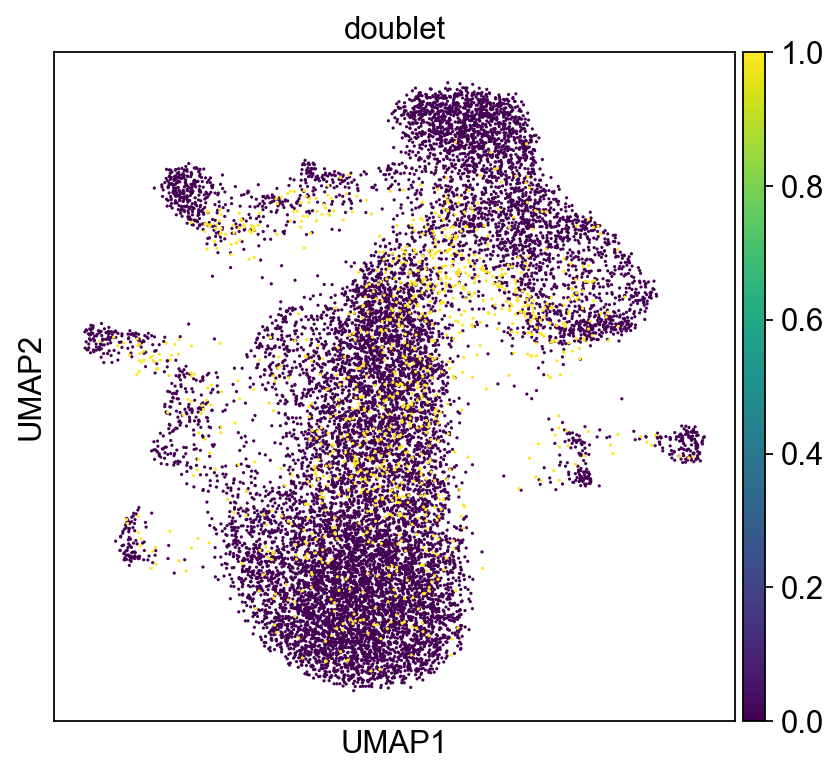

In [20]:
rcParams['figure.figsize'] = 6, 5.5
sc.pl.umap(adata, color=['doublet'])

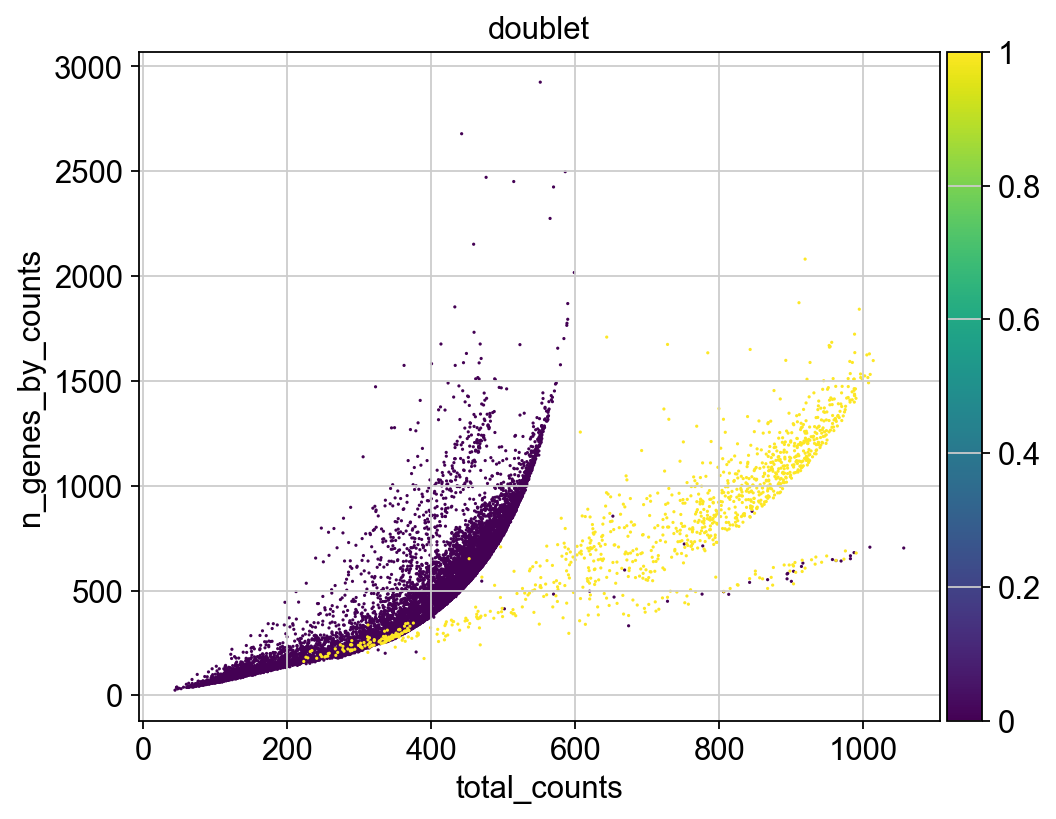

In [21]:
sc.pl.scatter(adata, 'total_counts', 'n_genes_by_counts', color='doublet')

### Exporting Doublets to a `.txt` file
Printing out doublet subsets for future comparisons

In [22]:
adata_dbl = adata.obs["scDblFinder_class"] == 'doublet'
adata_dbl = adata.obs_names[adata_dbl]

In [23]:
print(adata_dbl)

Index(['rDbl.2', 'rDbl.3', 'rDbl.4', 'rDbl.6', 'rDbl.7', 'rDbl.8', 'rDbl.9',
       'rDbl.10', 'rDbl.11', 'rDbl.13',
       ...
       'TGTTATGAGGACGTAA_sc85_1g', 'TGTTCATTCCTAAGAC_sc85_1g',
       'TTAGGCCCACCGGCTA_sc85_1g', 'TTAGTCAAGTGCTGTG_sc85_1g',
       'TTATGACCATAATTGC_sc85_1g', 'TTGAGGCGTATTGCAG_sc85_1g',
       'TTGCAACAGGTTTGAC_sc85_1g', 'TTGTGCCTCGCTTCTA_sc85_1g',
       'TTTCACCCACTAAGAA_sc85_1g', 'TTTGTGTTCGATTATG_sc85_1g'],
      dtype='object', length=1106)


In [24]:
with open("./sc85_1g_IDs/scDblFinder_sc85_1g_pseudo_ids.txt", "w") as txt_file:
    for cell in adata_dbl:
        txt_file.write(cell + "\n")